# import

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, odr

In [2]:
import constant_si26ap

# functions

In [3]:
def assign_channel(value, defined_values):
    """
    Returns the index of the closest value in defined_values to the given value.

    Parameters:
        value (float): The value to match.
        defined_values (array-like): A sorted array of reference values.

    Returns:
        int: Index of the closest value in defined_values.

    Raises:
        ValueError: If defined_values is empty or not a valid array.
    """
    if not isinstance(defined_values, (np.ndarray, list)):
        raise ValueError("defined_values must be an array-like object.")
    if len(defined_values) == 0:
        raise ValueError("defined_values cannot be empty.")

    defined_values = np.asarray(defined_values)  # Ensure NumPy array
    closest_index = np.argmin(np.abs(defined_values - value))
    return closest_index

In [4]:
def calculate_histogram_statistics(file_pattern, x_edges, y_edges, data_column=1):
    """
    Calculate average and standard deviation histograms from files matching a pattern.

    Parameters:
        file_pattern (str): Pattern of files to read (e.g., 'main_*.txt').
        x_edges (array-like): Bin edges for the X-axis.
        y_edges (array-like): Bin edges for the Y-axis.
        data_column (int): Column index in the text file to use for histogram data.

    Returns:
        hist_avg (np.ndarray): Average histogram for all files (1D).
        hist_std (np.ndarray): Standard deviation of the histogram (1D).
        channel_hists_avg (np.ndarray): Average histograms for each channel (2D).
        channel_hists_std (np.ndarray): Standard deviations for each channel (2D).
    """
    files = sorted(glob.glob(file_pattern))
    total_histograms = []
    channel_histograms = []
    print(f"process {len(files)} files")

    for file in files:
        # Load data
        data = np.loadtxt(file, delimiter=",", usecols=(data_column, 2))
        x_values = data[:, 0]
        y_values_original = data[:, 1]
        y_values = [
            assign_channel(value, constant_si26ap.excited_energies)
            for value in y_values_original
        ]
        # Compute 2D histogram
        hist_2d, _, _ = np.histogram2d(x_values, y_values, bins=[x_edges, y_edges])

        # Summing along the Y-axis for total histogram
        total_histograms.append(hist_2d.sum(axis=1))

        # Extracting individual channel histograms
        channel_histograms.append(hist_2d.T)

    # Convert lists to NumPy arrays
    total_histograms = np.array(total_histograms)
    channel_histograms = np.array(channel_histograms)

    # Calculate statistics for total histograms
    hist_avg = np.mean(total_histograms, axis=0)
    hist_std = np.std(total_histograms, axis=0)

    # Calculate statistics for channel histograms
    channel_hists_avg = np.mean(channel_histograms, axis=0)
    channel_hists_std = np.std(channel_histograms, axis=0)

    # Debugging and test code
    rng = np.random.default_rng()
    x_bin = rng.integers(len(x_edges) - 1)
    x_center = (x_edges[x_bin] + x_edges[x_bin + 1]) / 2
    total_sum = np.sum(total_histograms[:, x_bin])
    channel_sums = []
    for i in range(len(y_edges) - 1):
        sum_channel = np.sum(channel_histograms[:, i, x_bin])
        channel_sums.append(sum_channel)
    total_channel_sum = np.sum(channel_sums)
    if total_sum != total_channel_sum:
        raise ValueError(f"x: {x_center}: {total_sum} == {total_channel_sum}")

    return hist_avg, hist_std, channel_hists_avg, channel_hists_std

In [5]:
def calculate_simulation_histogram(file_pattern, x_edges, total_scale, data_column=1):
    """
    Calculate histograms from simulation data files and scale them.

    Parameters:
        file_pattern (str): Glob pattern to match the files.
        x_edges (array-like): Edges of the histogram bins.
        total_scale (float): Scaling factor.
        data_column (int): Column index to extract data from (default is 1).

    Returns:
        total_hist (np.ndarray): Summed histogram across all files.
        sim_histograms (np.ndarray): Individual scaled histograms for each file.
    """
    files = sorted(glob.glob(file_pattern))
    histograms = []
    print(f"process {len(files)} files")

    for i, file in enumerate(files):
        # Load data
        data = np.loadtxt(file, delimiter=",", usecols=(data_column, 2))
        x_values = data[:, 0]
        y_values_original = data[:, 1]
        y_values = [
            assign_channel(value, constant_si26ap.excited_energies)
            for value in y_values_original
        ]
        if False and y_values[0] > 5:
            continue

        hist, _ = np.histogram(x_values, bins=x_edges)

        scaled_hist = hist * constant_si26ap.apx_sim_scale[i] * total_scale
        histograms.append(scaled_hist)

    # Convert lists to NumPy arrays
    sim_histograms = np.array(histograms)
    total_hist = np.sum(sim_histograms, axis=0)

    return total_hist, sim_histograms

# main

In [6]:
bg_factor = constant_si26ap.bg_factor
max_levels = 40
y_bins = max_levels + 1
y_min, y_max = -0.5, max_levels + 0.5
y_edges = np.linspace(y_min, y_max, y_bins + 1)

### CM system

In [7]:
x_bins = 12
x_min, x_max = 2.0, 8.0
x_edges = np.linspace(x_min, x_max, x_bins + 1)

In [8]:
# assuming 2.25 to 7.75
ecm_errors = [
    0.3106450403840907,
    0.3027276903025209,
    0.3063070039585142,
    0.29961696067867916,
    0.2855377061783317,
    0.2593590079715275,
    0.23691880250641795,
    0.21564066175507987,
    0.1980220918554955,
    0.18311679515694212,
    0.16654348104181596,
    0.14922353571234878,
]
ecm_errors = np.array(ecm_errors)

In [9]:
phys_hist_avg, phys_hist_std, phys_channel_hists_avg, phys_channel_hists_std = (
    calculate_histogram_statistics(
        f"yield/{max_levels}/high_*.txt", x_edges, y_edges, 1
    )
)

process 1000 files


In [10]:
bg_hist_avg, bg_hist_std, bg_channel_hists_avg, bg_channel_hists_std = (
    calculate_histogram_statistics(
        f"yield/{max_levels}/bg_*.txt", x_edges, y_edges, 1
    )
)

process 1000 files


In [11]:
main_hist = phys_hist_avg - (bg_hist_avg * bg_factor)
main_channel_hists = phys_channel_hists_avg - (bg_channel_hists_avg * bg_factor)

In [12]:
phys_hist_sqrt = np.sqrt(phys_hist_avg)
bg_hist_sqrt = np.sqrt(bg_hist_avg)

main_hist_std = np.sqrt(phys_hist_std**2 + (bg_hist_std * bg_factor) ** 2)
main_hist_sqrt = np.sqrt(phys_hist_sqrt**2 + (bg_hist_sqrt * bg_factor) ** 2)
main_hist_sigma = np.sqrt(main_hist_std**2 + main_hist_sqrt**2)

In [13]:
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
print(x_bin_centers)

[2.25 2.75 3.25 3.75 4.25 4.75 5.25 5.75 6.25 6.75 7.25 7.75]


In [14]:
output_file_path = "yield/yield_40.txt"
with open(output_file_path, mode="w") as file:
    for x, y in zip(x_bin_centers, main_hist):
        file.write(f"{x}, {y}\n")

output_file_path = "yield/yield_40_modelerror.txt"
with open(output_file_path, mode="w") as file:
    for x, y in zip(x_bin_centers, main_hist_std):
        file.write(f"{x}, {y}\n")

output_file_path = "yield/yield_40_staterror.txt"
with open(output_file_path, mode="w") as file:
    for x, y in zip(x_bin_centers, main_hist_sqrt):
        file.write(f"{x}, {y}\n")

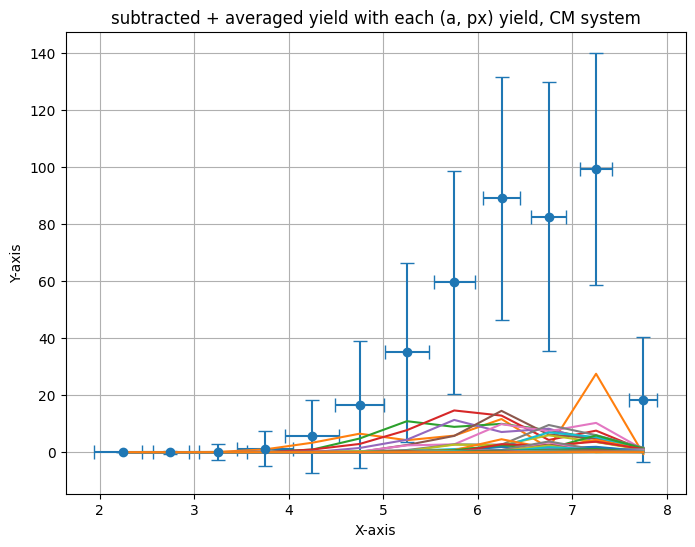

In [15]:
plt.figure(figsize=(8, 6))

plt.errorbar(
    x_bin_centers,
    main_hist,
    xerr=ecm_errors,
    yerr=main_hist_sigma,
    fmt="o",
    label="Dataset 1 (with error bars)",
    capsize=5,
)

for hist in main_channel_hists:
    plt.plot(
        x_bin_centers, hist, "-", label="Dataset 2 (no error bars)"
    )

plt.title("subtracted + averaged yield with each (a, px) yield, CM system")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
#plt.legend()
plt.grid(True)

plt.savefig(
    f"figure/fig_raw/total_and_each_yield_cm.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [16]:
sim_scale_factor = 1.477828e-02
print(f"{sim_scale_factor:e}")
x_bins = 100
x_edges = np.linspace(x_min, x_max, x_bins + 1)

1.477828e-02


In [17]:
sim_total_hist, sim_channel_hists = calculate_simulation_histogram(
    f"yield/sim/ap_*.txt", x_edges, sim_scale_factor, 1
)

process 41 files


In [18]:
x_sim_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2

In [19]:
f_interp = interpolate.interp1d(x_sim_bin_centers, sim_total_hist, kind="linear", fill_value="extrapolate")


def model_func(beta, x):
    scale = beta[0]
    return scale * f_interp(x)

model = odr.Model(model_func)
data = odr.RealData(x_bin_centers[5:], main_hist[5:], sx=ecm_errors[5:], sy=main_hist_sigma[5:])
odr_instance = odr.ODR(data, model, beta0=[1.0])
output = odr_instance.run()
fitted_scale = output.beta[0]
scale_error = output.sd_beta[0]
chi_squared = output.sum_square

N = len(x_bin_centers[5:])
p = len(output.beta)
dof = N - p
reduced_chi_squared = chi_squared / dof

print("Fitted scale parameter:", fitted_scale)
print("standard deviation:", scale_error)
print("chi2:", chi_squared)
print("dof:", dof)
print("Reduced Chi-Squared:", reduced_chi_squared)

Fitted scale parameter: 1.0000062463177013
standard deviation: 0.23863079465627746
chi2: 4.525426378803077
dof: 6
Reduced Chi-Squared: 0.7542377298005128


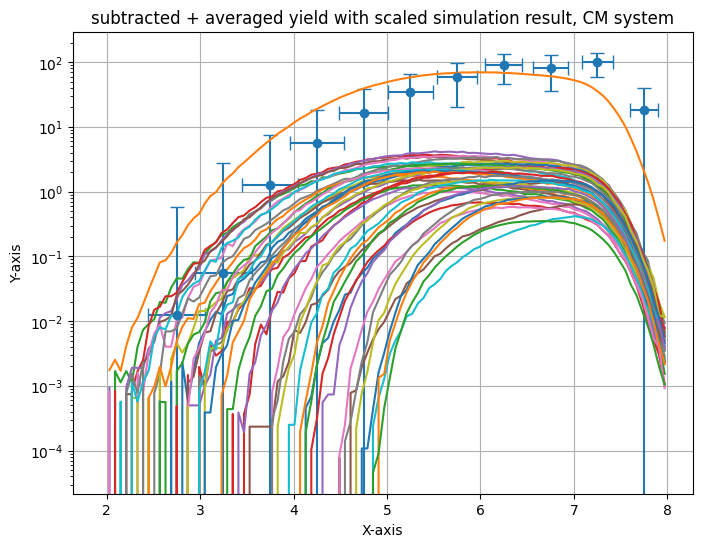

In [20]:
plt.figure(figsize=(8, 6))

plt.errorbar(
    x_bin_centers,
    main_hist,
    xerr=ecm_errors,
    yerr=main_hist_sigma,
    fmt="o",
    label="Dataset 1 (with error bars)",
    capsize=5,
)

plt.plot(x_sim_bin_centers, sim_total_hist, "-")

#plot_indexes = [0, 10, 20, 30, 40]
#for i in plot_indexes:
#    plt.plot(
#        x_sim_bin_centers, sim_channel_hists[i], "-", label="Dataset 2 (no error bars)"
#    )
for hist in sim_channel_hists:
    plt.plot(
        x_sim_bin_centers, hist, "-", label="Dataset 2 (no error bars)"
    )

plt.title("subtracted + averaged yield with scaled simulation result, CM system")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.yscale("log")
# plt.legend()
plt.grid(True)

plt.savefig(
    f"figure/fig_raw/total_and_sim_yield_cm.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### LAB system

In [21]:
x_bins = 25
x_min, x_max = 5.0, 30.0
x_edges = np.linspace(x_min, x_max, x_bins + 1)

In [22]:
phys_hist_avg, phys_hist_std, phys_channel_hists_avg, phys_channel_hists_std = (
    calculate_histogram_statistics(
        f"yield/{max_levels}/high_*.txt", x_edges, y_edges, 3
    )
)
print(phys_hist_std)

process 1000 files
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [23]:
bg_hist_avg, bg_hist_std, bg_channel_hists_avg, bg_channel_hists_std = (
    calculate_histogram_statistics(
        f"yield/{max_levels}/bg_*.txt", x_edges, y_edges, 3
    )
)
print(bg_hist_std)

process 1000 files
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [24]:
main_hist = phys_hist_avg - (bg_hist_avg * bg_factor)
main_channel_hists = phys_channel_hists_avg - (bg_channel_hists_avg * bg_factor)

In [25]:
phys_hist_sqrt = np.sqrt(phys_hist_avg)
bg_hist_sqrt = np.sqrt(bg_hist_avg)

main_hist_std = np.sqrt(phys_hist_std**2 + (bg_hist_std * bg_factor) ** 2)
main_hist_sqrt = np.sqrt(phys_hist_sqrt**2 + (bg_hist_sqrt * bg_factor) ** 2)
main_hist_sigma = np.sqrt(main_hist_std**2 + main_hist_sqrt**2)

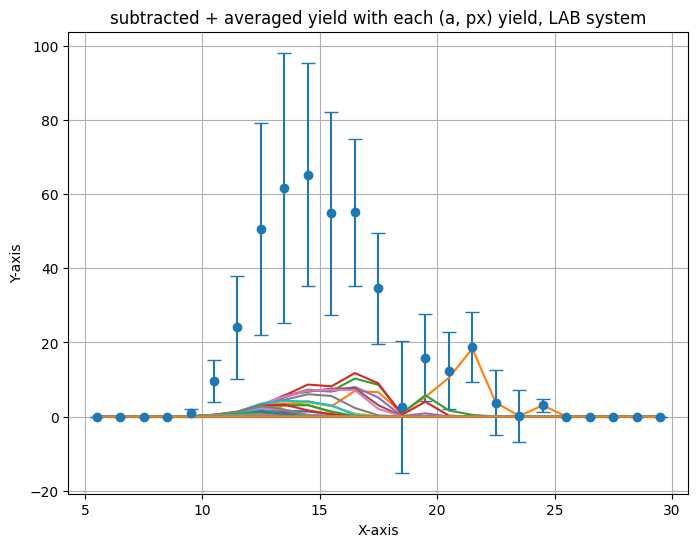

In [26]:
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
plt.figure(figsize=(8, 6))

plt.errorbar(
    x_bin_centers,
    main_hist,
    yerr=main_hist_sigma,
    fmt="o",
    label="Dataset 1 (with error bars)",
    capsize=5,
)

for hist in main_channel_hists:
    plt.plot(
        x_bin_centers, hist, "-", label="Dataset 2 (no error bars)"
    )

plt.title("subtracted + averaged yield with each (a, px) yield, LAB system")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
#plt.legend()
plt.grid(True)

plt.savefig(
    f"figure/fig_raw/total_and_each_yield_lab.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [27]:
sim_scale_factor = 3.0e-2
x_bins = 100
x_edges = np.linspace(x_min, x_max, x_bins + 1)

In [28]:

sim_total_hist, sim_channel_hists = calculate_simulation_histogram(
    f"yield/sim/ap_*.txt", x_edges, sim_scale_factor, 3
)

process 41 files


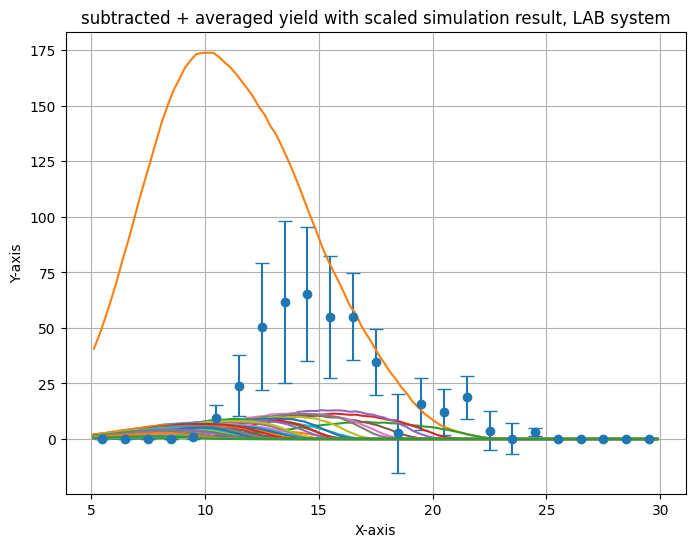

In [29]:
x_sim_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
plt.figure(figsize=(8, 6))

plt.errorbar(
    x_bin_centers,
    main_hist,
    yerr=main_hist_sigma,
    fmt="o",
    label="Dataset 1 (with error bars)",
    capsize=5,
)

plt.plot(x_sim_bin_centers, sim_total_hist, "-")

#plot_indexes = [0, 10, 20, 30, 40]
#for i in plot_indexes:
#    plt.plot(
#        x_sim_bin_centers, sim_channel_hists[i], "-", label="Dataset 2 (no error bars)"
#    )
for hist in sim_channel_hists:
    plt.plot(
        x_sim_bin_centers, hist, "-", label="Dataset 2 (no error bars)"
    )

plt.title("subtracted + averaged yield with scaled simulation result, LAB system")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
#plt.yscale("log")
# plt.legend()
plt.grid(True)

plt.savefig(
    f"figure/fig_raw/total_and_sim_yield_lab.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [30]:
factor = 4.00150609413 / (25.9846537 + 4.00150609413)  # Lab -> CM

cm_bins = 16
cm_min, cm_max = 0.0, 8.0
cm_edges = np.linspace(cm_min, cm_max, cm_bins + 1)
cm_bin_centers = (cm_edges[:-1] + cm_edges[1:]) / 2
print(cm_bin_centers)
print(cm_bin_centers / factor)

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 5.25 5.75 6.25 6.75
 7.25 7.75]
[ 1.8734296   5.62028879  9.36714798 13.11400718 16.86086637 20.60772556
 24.35458476 28.10144395 31.84830315 35.59516234 39.34202153 43.08888073
 46.83573992 50.58259911 54.32945831 58.0763175 ]
